In [93]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs


fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [94]:
!ls german-traffic-signs


signnames.csv  test.p  train.p	valid.p


In [95]:
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

In [97]:
np.random.seed(0)

In [98]:
# Implement load the data here.

with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

print(type(train_data))

<class 'dict'>


In [99]:
# Split out features and labels

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [100]:
print(X_train.shape)           # no. of images * pixels * pixels * depth
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [101]:
# To check if the images are correctly labled

assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

In [102]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)
#print(data.head)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

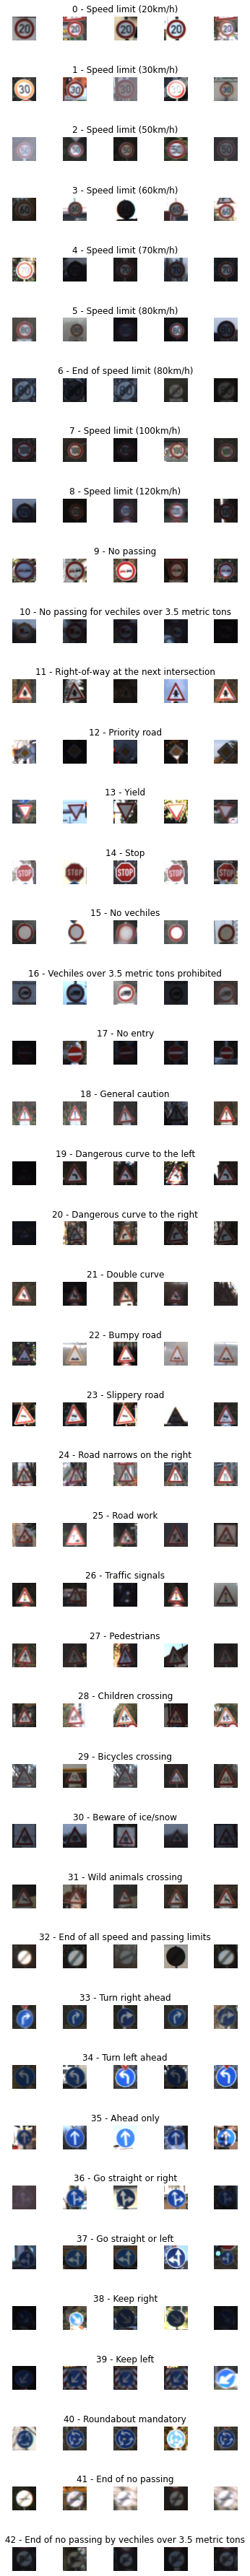

In [103]:
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


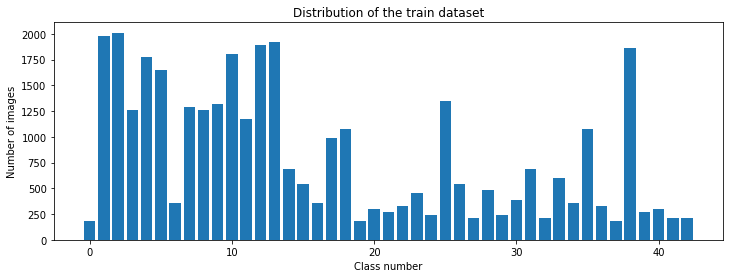

In [104]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
#plt.grid()
plt.show()

# As we can see, some classes have more images and some of then have less images. 

(32, 32, 3)
36


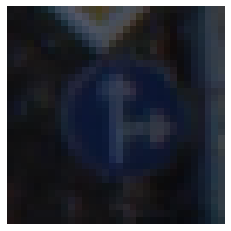

In [105]:
# Preprocessing the images is required as, diffrent images has differnt background and unique features
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


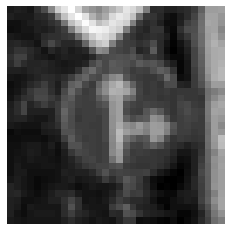

In [106]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img
#plt.imshow(img)
img = grayscale(X_train[1000])
plt.imshow(img,cmap=plt.get_cmap('gray'))                                                     
plt.axis("off")
print(img.shape)


(32, 32)


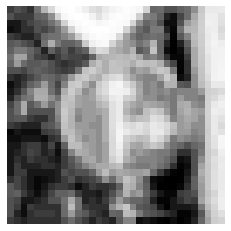

In [107]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

In [108]:
def preprocess(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255    # Normalisation = All pixel values are normalised between 0 and 1
  return img 


In [109]:
# Preprocessing train,val,test data sets in a sequence

# map() = Iterate through the entire array and for every element of the array, returns a new element based on the specified function 
# creating a new array with updated values.
#list() = is used to store the return values of map().

X_train = np.array(list(map(preprocess, X_train)))    
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 

(34799, 32, 32)


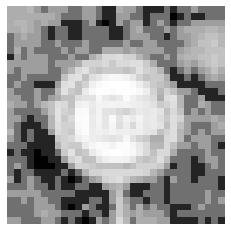

In [110]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)],cmap=plt.get_cmap('gray'))
#plt.imshow(img,cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)

In [111]:
# We add depth to a greyscale image, as CNN requires depth value
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [112]:
# Data Augmentation to detect the extra features as, no. of images in classes are dis-proportionate 

from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,  # horizontal offset
                            height_shift_range=0.1, # vertical shift
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

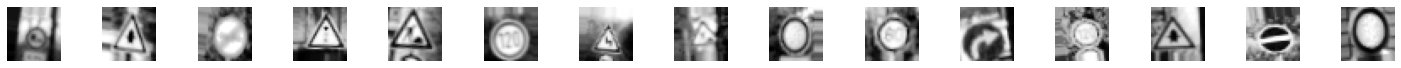

In [113]:
batches = datagen.flow(X_train, y_train, batch_size = 15)   # Augmentation is done when requested. As, it is very memory consuming
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32),cmap=plt.get_cmap('gray'))
    #plt.imshow(img,cmap=plt.get_cmap('gray'))
    axs[i].axis("off")

In [114]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(X_batch.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)
(15, 32, 32, 1)


In [115]:
# One-hot encoding

y_train = to_categorical(y_train, 43)    # for 43 classes
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [116]:
# The same model is modified by adding extra layers, and dropout layers to reduce overfitting.
# The accuracy was improved even more.

def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation = 'softmax'))

  #Compile model
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model



In [117]:
model = modified_model()
# print(model.summary())

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [127]:
# history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),steps_per_epoch=695, epochs=10, validation_data=(X_val, y_val), shuffle = 1)
#steps_per_epoch = int(len(X_train)/batch_size)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=X_train.shape[0]/50,epochs=15, validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/15
  4/695 [..............................] - ETA: 12s - loss: 0.1291 - accuracy: 0.9600

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


695/695 [==============================] - 13s 19ms/step - loss: 0.1073 - accuracy: 0.9684 - val_loss: 0.0610 - val_accuracy: 0.9839
Epoch 2/15
695/695 [==============================] - 13s 19ms/step - loss: 0.0996 - accuracy: 0.9693 - val_loss: 0.0278 - val_accuracy: 0.9925
Epoch 3/15
695/695 [==============================] - 13s 19ms/step - loss: 0.0936 - accuracy: 0.9707 - val_loss: 0.0532 - val_accuracy: 0.9862
Epoch 4/15
695/695 [==============================] - 13s 19ms/step - loss: 0.0865 - accuracy: 0.9734 - val_loss: 0.0361 - val_accuracy: 0.9893
Epoch 5/15
695/695 [==============================] - 15s 21ms/step - loss: 0.0831 - accuracy: 0.9741 - val_loss: 0.0242 - val_accuracy: 0.9921
Epoch 6/15
695/695 [==============================] - 13s 18ms/step - loss: 0.0836 - accuracy: 0.9742 - val_loss: 0.0233 - val_accuracy: 0.9934
Epoch 7/15
695/695 [==============================] - 13s 18ms/step - loss: 0.0816 - accuracy: 0.9758 - val_loss: 0.0327 - val_accuracy: 0.9912
Epo

Text(0.5, 0, 'epoch')

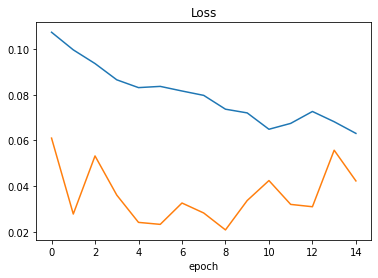

In [128]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

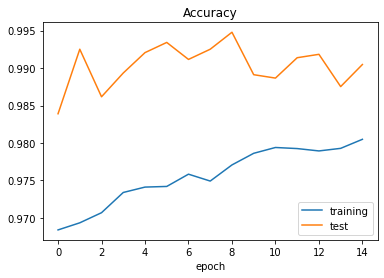

In [129]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [131]:
# To Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.13394466042518616
Test accuracy: 0.970546305179596


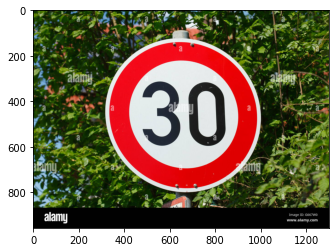

In [132]:
#predict image from internet 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'

# url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
# url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
# url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
# url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'

r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


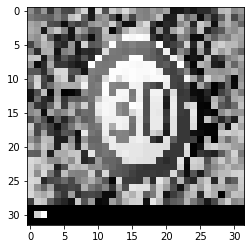

In [133]:
# Preprocess the image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))  # As we test our neral net on 32*32 images
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)


In [134]:
img = img.reshape(1, 32, 32, 1)

In [135]:
# Model predicts the class of the image taken from internet as true or false 
pred = np.argmax(model.predict(img), axis =-1)
print("Predicted sign: " + str(pred))


Predicted sign: [1]


In [ ]:
# All the 5 images taken from the internet, predicted the correct class of traffic sign. This shows that our model is very effective and accurate.

In [ ]:
"""
> The validation actually converges to above 99 percent, which is a significant improvement over our previous model.
> Also we have a much smaller gap between our training loss and training accuracy, as well as the validation,loss and accuracy, respectively.
  And this demonstrates consistency in our training and implies a better trained model.
> After finishing the model training with a validation accuracy of over 99 percent and a training accuracy almost 98 percent, which is higher than what the model could provide without the fit
  generator(Image Augmentation).

> After evaluating the accuracy on test data, this also gives a pretty high relative accuracy of almost 98 percent.
> This shows that our data augmentation technique was effective.
> Also on web images the modified model predicts the class correctly, and the model was successful.

> CONCLUSION: This data augmentation technique of transforming and altering images to create more variety was quite effective
  and improved the accuracy of our model.
"""